In [1]:
!pip3 install kaggle tqdm

In [2]:
!kaggle datasets download -d ebrahimelgazar/pixel-art
!unzip -p pixel-art.zip sprites.npy > sprites.npy
!unzip -p pixel-art.zip sprites_labels.npy > sprites_labels.npy

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
 97% 83.0M/85.7M [00:05<00:00, 21.9MB/s]
100% 85.7M/85.7M [00:05<00:00, 16.6MB/s]


In [3]:
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_attention.py --output m_attention.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_convolutional.py --output m_convolutional.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_diffusion.py --output m_diffusion.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_downblock.py --output m_downblock.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_model.py --output m_model.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_tools.py --output m_tools.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_unet.py --output m_unet.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_upblock.py --output m_upblock.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3145  100  3145    0     0   6062      0 --:--:-- --:--:-- --:--:--  6071
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1197  100  1197    0     0   1944      0 --:--:-- --:--:-- --:--:--  1946
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1906  100  1906    0     0   3935      0 --:--:-- --:--:-- --:--:--  3929
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2368  100  2368    0     0   4686      0 --:--:-- --:--:-- --:--:--  4689
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
import numpy as np
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from PIL import Image

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
labels = Tensor(np.load('sprites_labels.npy').argmax(axis=1)).type(torch.long)
labels.shape

torch.Size([89400])

In [6]:
image = np.load('sprites.npy').astype(np.float32) / 255
image = Tensor(image.swapaxes(-1, 1))
image = image * 2 - 1

image.shape

torch.Size([89400, 3, 16, 16])

In [7]:
import math, random
from m_model import Model
from m_diffusion import Diffusion

In [20]:
def genereate_image(model:nn.Module, diffusion:Diffusion, device='cpu'):
  n = 4
  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((n, 3, 16, 16), device=device)
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    for i in reversed(range(1, 1000)):
      t = (torch.ones(n, device=device) * i).long()
      predicted:Tensor = model(x, t)
      alpha = diffusion.alphas[t][:, None, None, None]
      alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
      beta = diffusion.betas[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)
      x = 1 / torch.sqrt(alpha) * (x - ((1-alpha)/(torch.sqrt(1 - alpha_hat)))*predicted) + torch.sqrt(beta)*noise
      pbar.update(1)
    pbar.close()

  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)

  for i in range(4):
    plt.subplot(2, 2, 1+i)
    plt.imshow(x.detach().cpu()[i].swapaxes(0, -1).numpy())
  plt.show()

In [10]:
c_in = 3
c_out = 3
embedding = 256
steps = 1000
categories=5
w_size = 16
h_size = 16

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
diffusion = Diffusion(steps, 'cosine', device=DEVICE)
DEVICE

device(type='cuda')

In [12]:
model = Model(c_in, c_out, w_size, h_size, steps, categories, embedding, device=DEVICE).to(DEVICE)

In [ ]:
model.load_state_dict(torch.load('model-30.pt', weights_only=False, map_location='cpu'))

<All keys matched successfully>

In [13]:
dataset = TensorDataset(image, labels)
dl = DataLoader(dataset, batch_size=2*512, shuffle=True, drop_last=True)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
loss_fn = nn.MSELoss()

Train (1/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

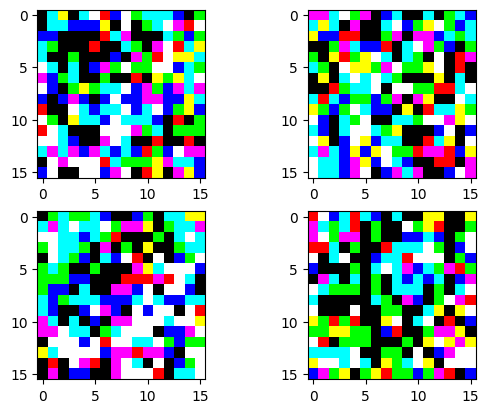

Train (2/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

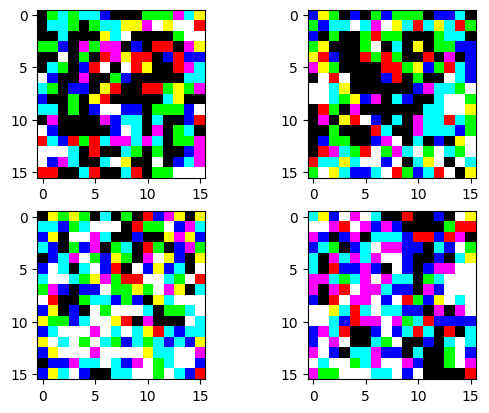

Train (3/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

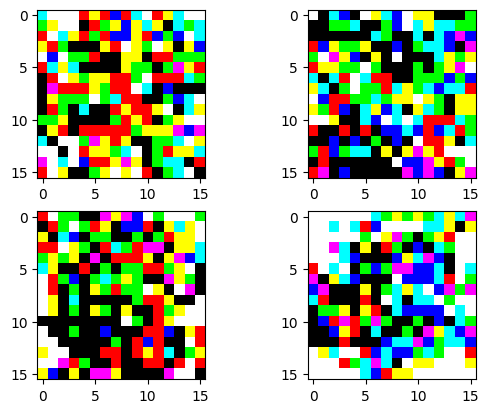

Train (4/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

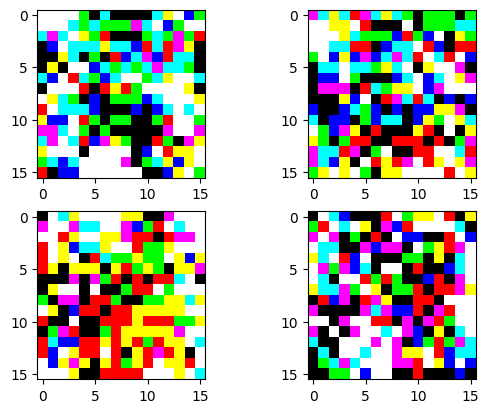

Train (5/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

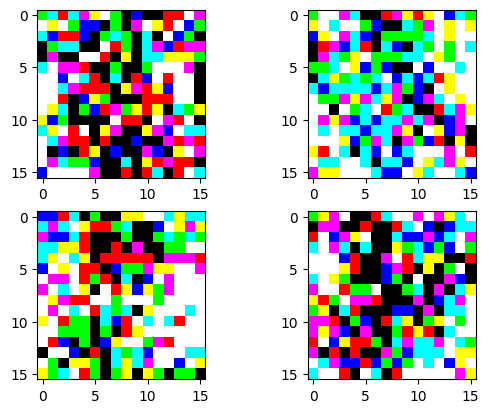

Train (6/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

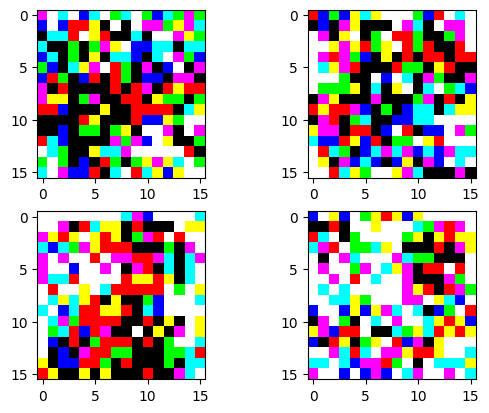

Train (7/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

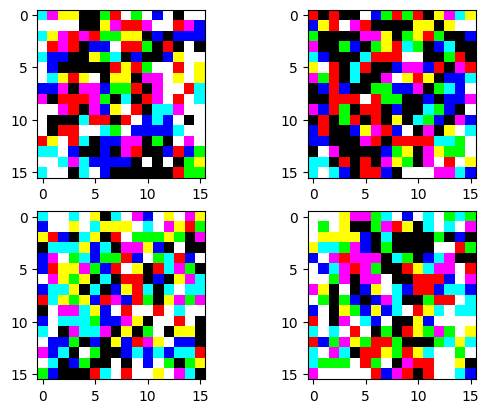

Train (8/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

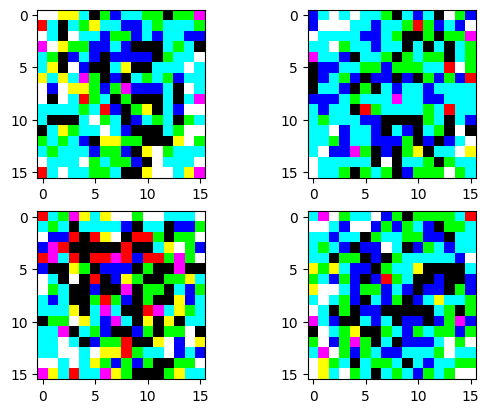

Train (9/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

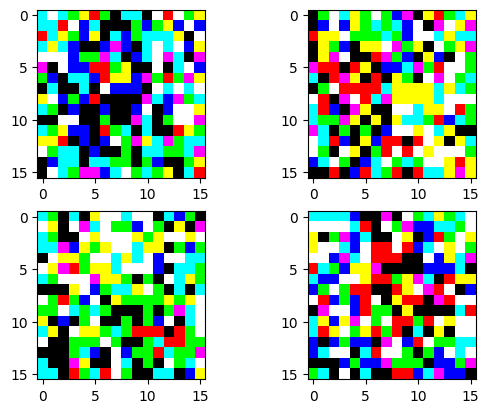

Train (10/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

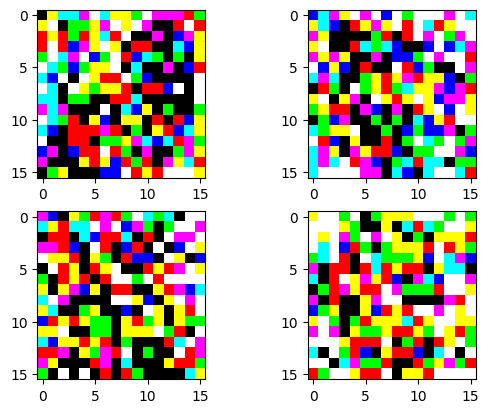

Train (11/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

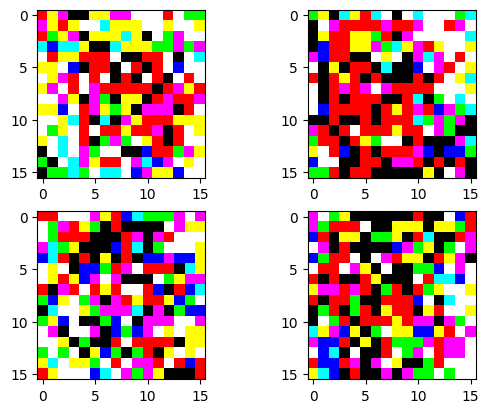

Train (12/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

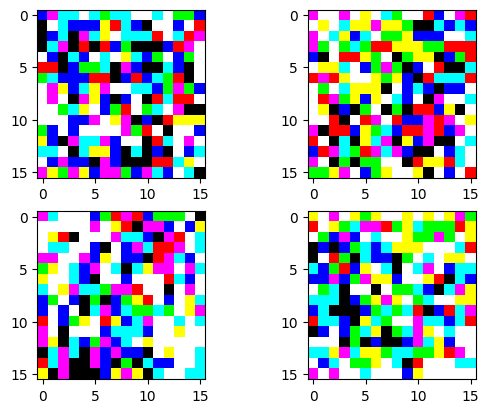

Train (13/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

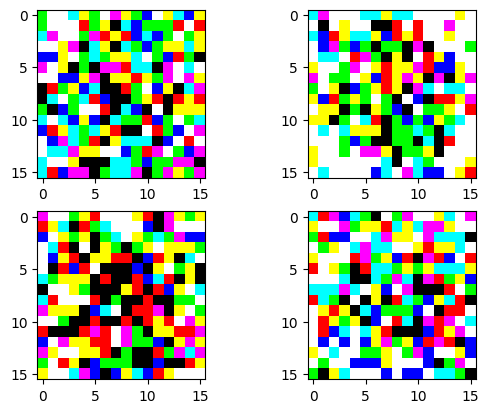

Train (14/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

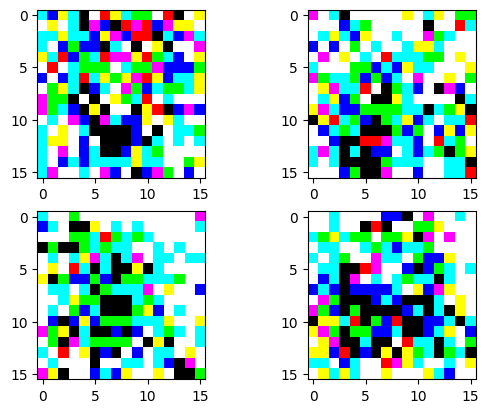

Train (15/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

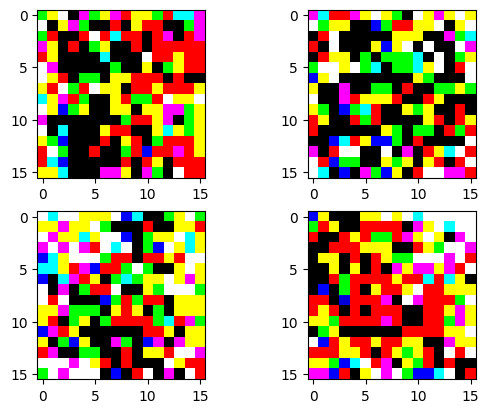

Train (16/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

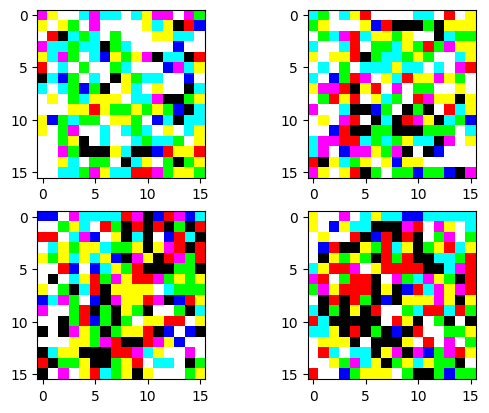

Train (17/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

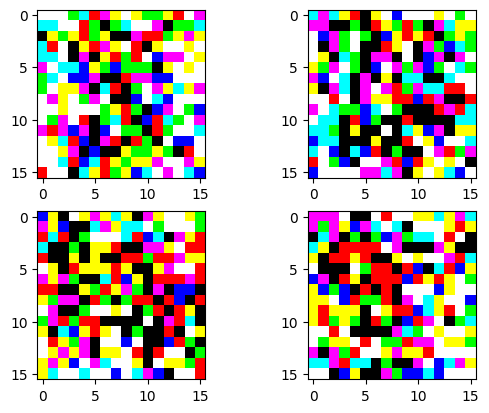

Train (18/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

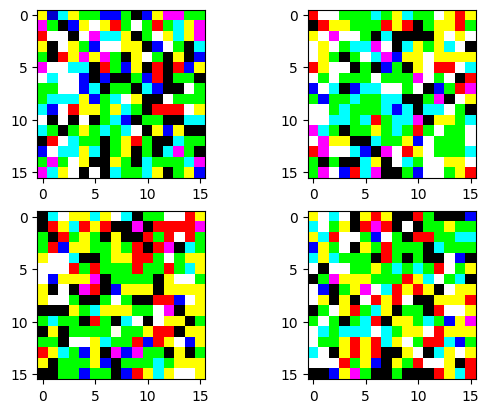

Train (19/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

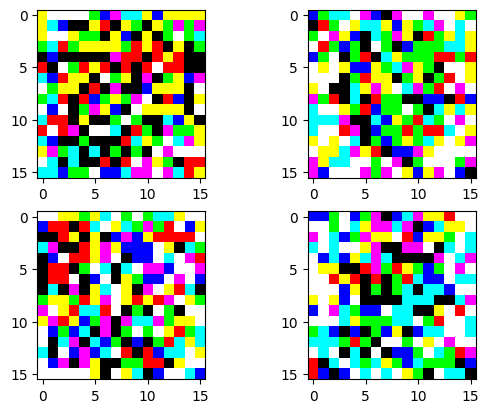

Train (20/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

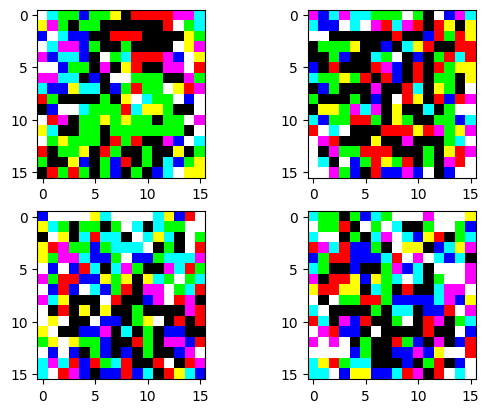

Train (21/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

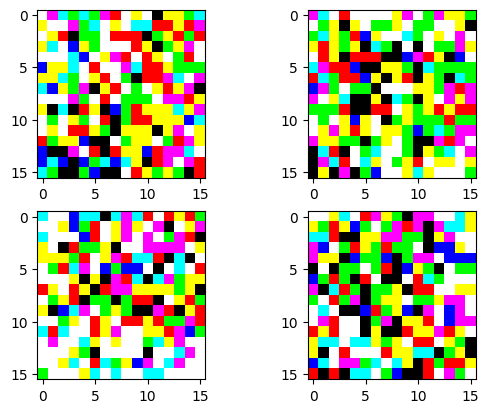

Train (22/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

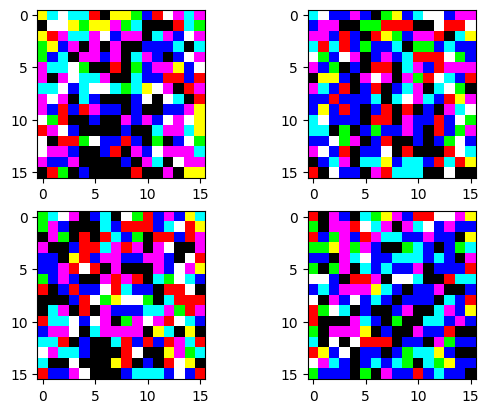

Train (23/30):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

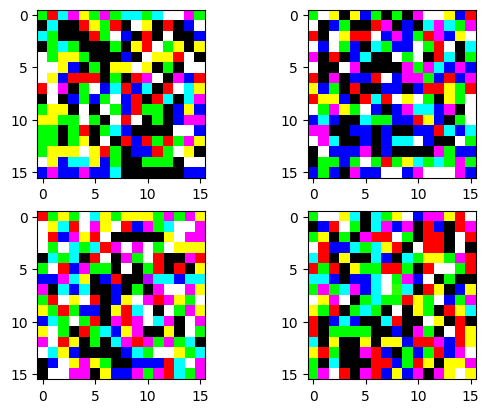

Train (24/30):   0%|          | 0/87 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
epochs = 30
for epoch in range(epochs):
  loss_total = 0

  pbar = tqdm(total=len(dl), desc=f'Train ({epoch+1}/{epochs})', position=0, colour='yellow')
  model.train()
  for X, Y in dl:
    X = X.to(DEVICE)
    Y = Y.to(DEVICE)

    t = torch.randint(low=0, high=steps, size=(X.shape[0],), device=DEVICE)
    x_t, noise = diffusion.noise_image(X, t)
    predicted = model(x_t, t, Y if random.random() < 0.1 else None)

    loss:Tensor = loss_fn(noise, predicted)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_total += loss.item() * X.shape[0]

    pbar.set_postfix(MSE=loss.item())
    pbar.update(1)

  loss_total /= len(dl.dataset)

  pbar.set_postfix(MSE=loss_total)
  pbar.close()

  torch.save(model.state_dict(), f'model-{epoch+1}.pt')

  genereate_image(model, diffusion, DEVICE)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

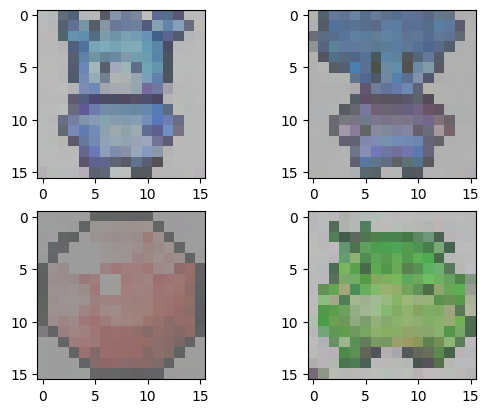

In [30]:
def genereate_image(model:nn.Module, diffusion:Diffusion, device='cpu'):
  n = 4
  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((n, 3, 16, 16), device=device)
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    for i in reversed(range(1, 1000)):
      t = (torch.ones(n, device=device) * i).long()
      predicted:Tensor = model(x, t)
      alpha = diffusion.alphas[t][:, None, None, None]
      alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
      beta = diffusion.betas[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)
      x = 1 / torch.sqrt(alpha) * (x - ((1-alpha)/(torch.sqrt(1 - alpha_hat)))*predicted)
      if i > 1:
        x = x.clamp(-1, 1)
      x = x + torch.sqrt(beta)*noise
      pbar.update(1)
    pbar.close()

  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)

  for i in range(4):
    plt.subplot(2, 2, 1+i)
    plt.imshow(x.detach().cpu()[i].swapaxes(0, -1).numpy())
  plt.show()

genereate_image(model, diffusion, DEVICE)

In [ ]:
from m_tools import create_sin_cos_encoding


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.0196e-01,  ...,  1.0000e+00,
          1.0746e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.5814e-01,  ...,  1.0000e+00,
          2.1492e-04,  1.0000e+00],
        ...,
        [-8.9797e-01, -4.4006e-01, -8.4710e-01,  ...,  9.9338e-01,
          1.0693e-01,  9.9427e-01],
        [-8.5547e-01,  5.1785e-01, -9.3224e-01,  ...,  9.9337e-01,
          1.0704e-01,  9.9425e-01],
        [-2.6461e-02,  9.9965e-01, -2.6668e-01,  ...,  9.9335e-01,
          1.0715e-01,  9.9424e-01]])

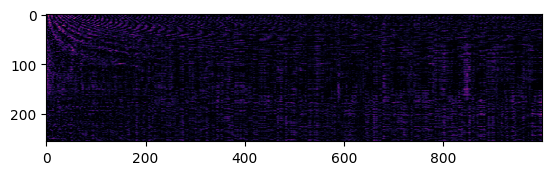

In [ ]:
x = (model.step_emb.weight.detach().cpu() - create_sin_cos_encoding(256, 1000))

plt.imshow(x.clip(0, 1).numpy().T, cmap='inferno')
plt.show()

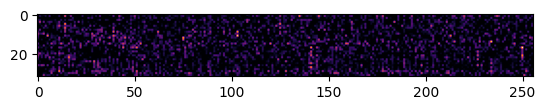

In [ ]:
x = (model.space_emb.weight.detach().cpu()[:16,:] - create_sin_cos_encoding(256, 16))
y = (model.space_emb.weight.detach().cpu()[16:,:] - create_sin_cos_encoding(256, 16))

plt.imshow(torch.cat((x,y), dim=0).clip(0, 1).numpy(), cmap='inferno')
plt.show()

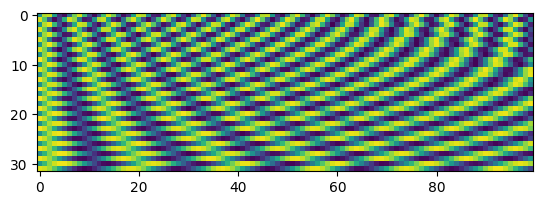

In [ ]:
#plt.subplot(3, 1, 1)
#plt.imshow(model.space_emb.weight.detach().cpu().numpy())
#plt.subplot(3, 1, 2)
#plt.imshow(model.category_emb.weight.detach().cpu().numpy())
#plt.subplot(3, 1, 3)
plt.imshow(model.step_emb.weight.detach().cpu().numpy().T[:32,:100])
plt.show()

In [17]:
def genereate_image(model:nn.Module, diffusion:Diffusion, c:int=0, device='cpu'):
  n = 4
  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((n, 3, 16, 16), device=device)
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    c = torch.ones(n, dtype=torch.long, device=device) * c

    for i in reversed(range(1, 1000)):
      t = (torch.ones(n, device=device) * i).long()
      predicted:Tensor = model(x, t, c)
      alpha = diffusion.alphas[t][:, None, None, None]
      alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
      beta = diffusion.betas[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)
      x = 1 / torch.sqrt(alpha) * (x - ((1-alpha)/(torch.sqrt(1 - alpha_hat)))*predicted) + torch.sqrt(beta)*noise
      pbar.update(1)
    pbar.close()

  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)

  for i in range(4):
    plt.subplot(2, 2, 1+i)
    plt.imshow(x.detach().cpu()[i].swapaxes(0, -1).numpy())
  plt.show()

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

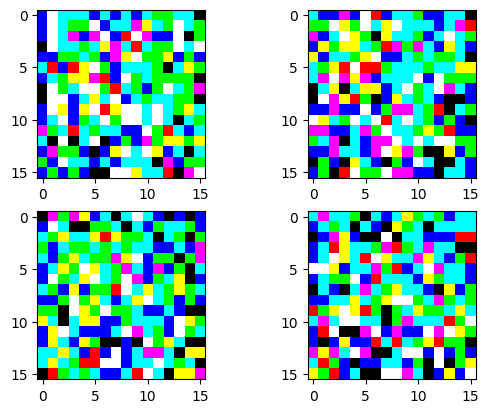

In [18]:
genereate_image(model, diffusion, 1, DEVICE)

Sampling: 100%|██████████| 1000/1000 [01:43<00:00,  9.71it/s]


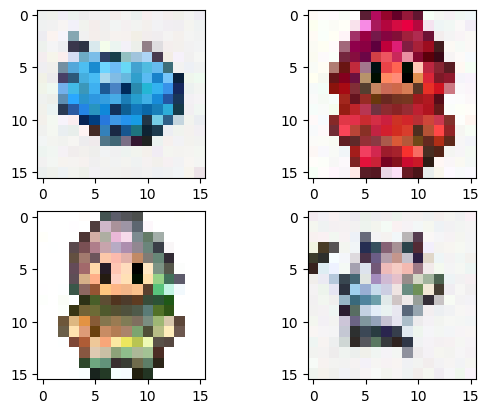

In [ ]:
genereate_image(model, diffusion, 0)

Sampling: 100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]


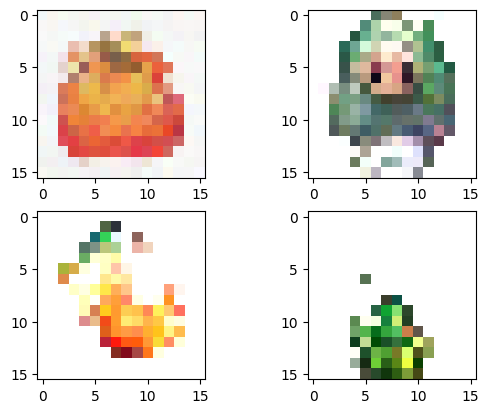

In [ ]:
genereate_image(model, diffusion, 2)

Sampling: 100%|██████████| 1000/1000 [01:39<00:00, 10.07it/s]


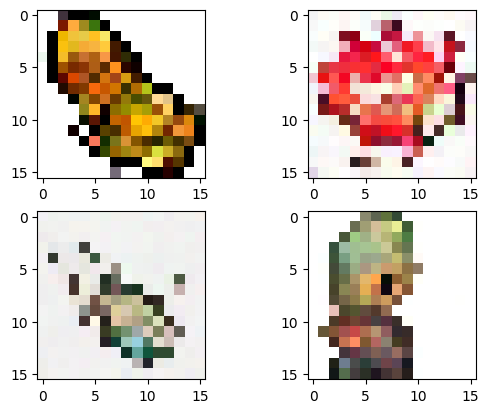

In [ ]:
genereate_image(model, diffusion, 3)

Sampling: 100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


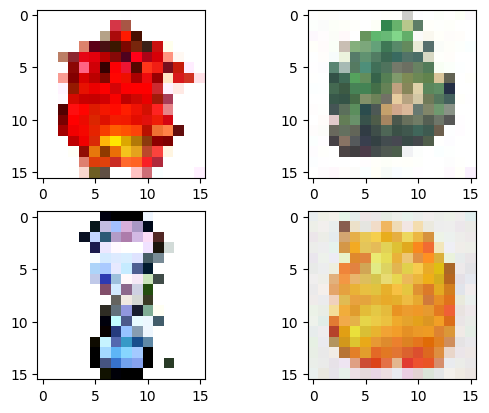

In [ ]:
genereate_image(model, diffusion, 4)

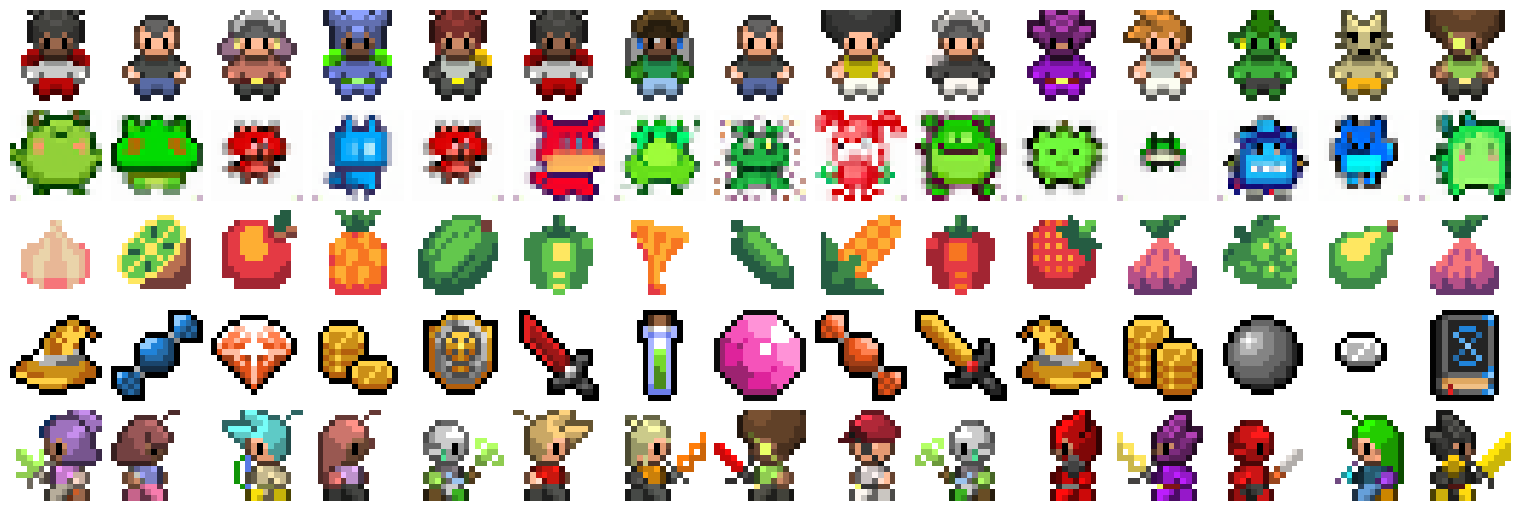

In [ ]:
s = 1
plt.figure(figsize=(s * 15, s * 5))
for i in range(5):
  imgs = image[labels == i]
  imgs = imgs[torch.randint(low=0, high=imgs.shape[0], size=(15,))]

  #[:15]
  for j in range(15):
    plt.subplot(5, 15, 15 * i + j + 1)
    plt.axis('off')
    plt.imshow(imgs[j].swapaxes(0, -1).numpy() * 0.5 + 0.5)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 1e-1)
plt.show()